# Model Plotting

Here we compare different interpolants together on the same dataset from saved models.

In [1]:
import math
import os
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import DEFunc, NeuralODE
from torchdyn.datasets import generate_moons
from torchdyn.nn import Augmenter

In [2]:
# Implement some helper functions


def sample_normal(n):
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
    return m.sample((n,))


def log_normal_density(x):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(x.shape[-1]), torch.eye(x.shape[-1])
    )
    return m.log_prob(x)


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def log_8gaussian_density(x, scale=5, var=0.1):
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    centers = centers.T.reshape(1, 2, 8)
    # calculate shifted xs [batch, centers, dims]
    x = (x[:, :, None] - centers).mT
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(x.shape[-1]), math.sqrt(var) * torch.eye(x.shape[-1])
    )
    log_probs = m.log_prob(x)
    log_probs = torch.logsumexp(log_probs, -1)
    return log_probs


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLP2(torch.nn.Module):
    """Change activations for Action Matching"""

    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.ReLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.0
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[
            0
        ][:, i]
    return trJ


class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, *args, **kwargs):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(
                torch.cat([x_in, t * torch.ones(x.shape[0], 1).type_as(x_in)], dim=-1)
            )
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [3]:
import torchcfm
savedir = "models/random-moons"
models = {
    "CFM": torch.load(f"{savedir}/cfm_v1.pt")
}

# "OT-CFM (ours)": torch.load(f"{savedir}/otcfm_v1.pt"),
# "SB-CFM (ours)": torch.load(f"{savedir}/sbcfm_v1.pt"),
# "VP-CFM": torch.load(f"{savedir}/stochastic_interpolant_v1.pt"),
# "Action-Matching": torch.load(f"{savedir}/action_matching_v1.pt"),
# "Action-Matching (Swish)": torch.load(f"{savedir}/action_matching_swish_v1.pt"),

KeyError: 'Action-Matching'

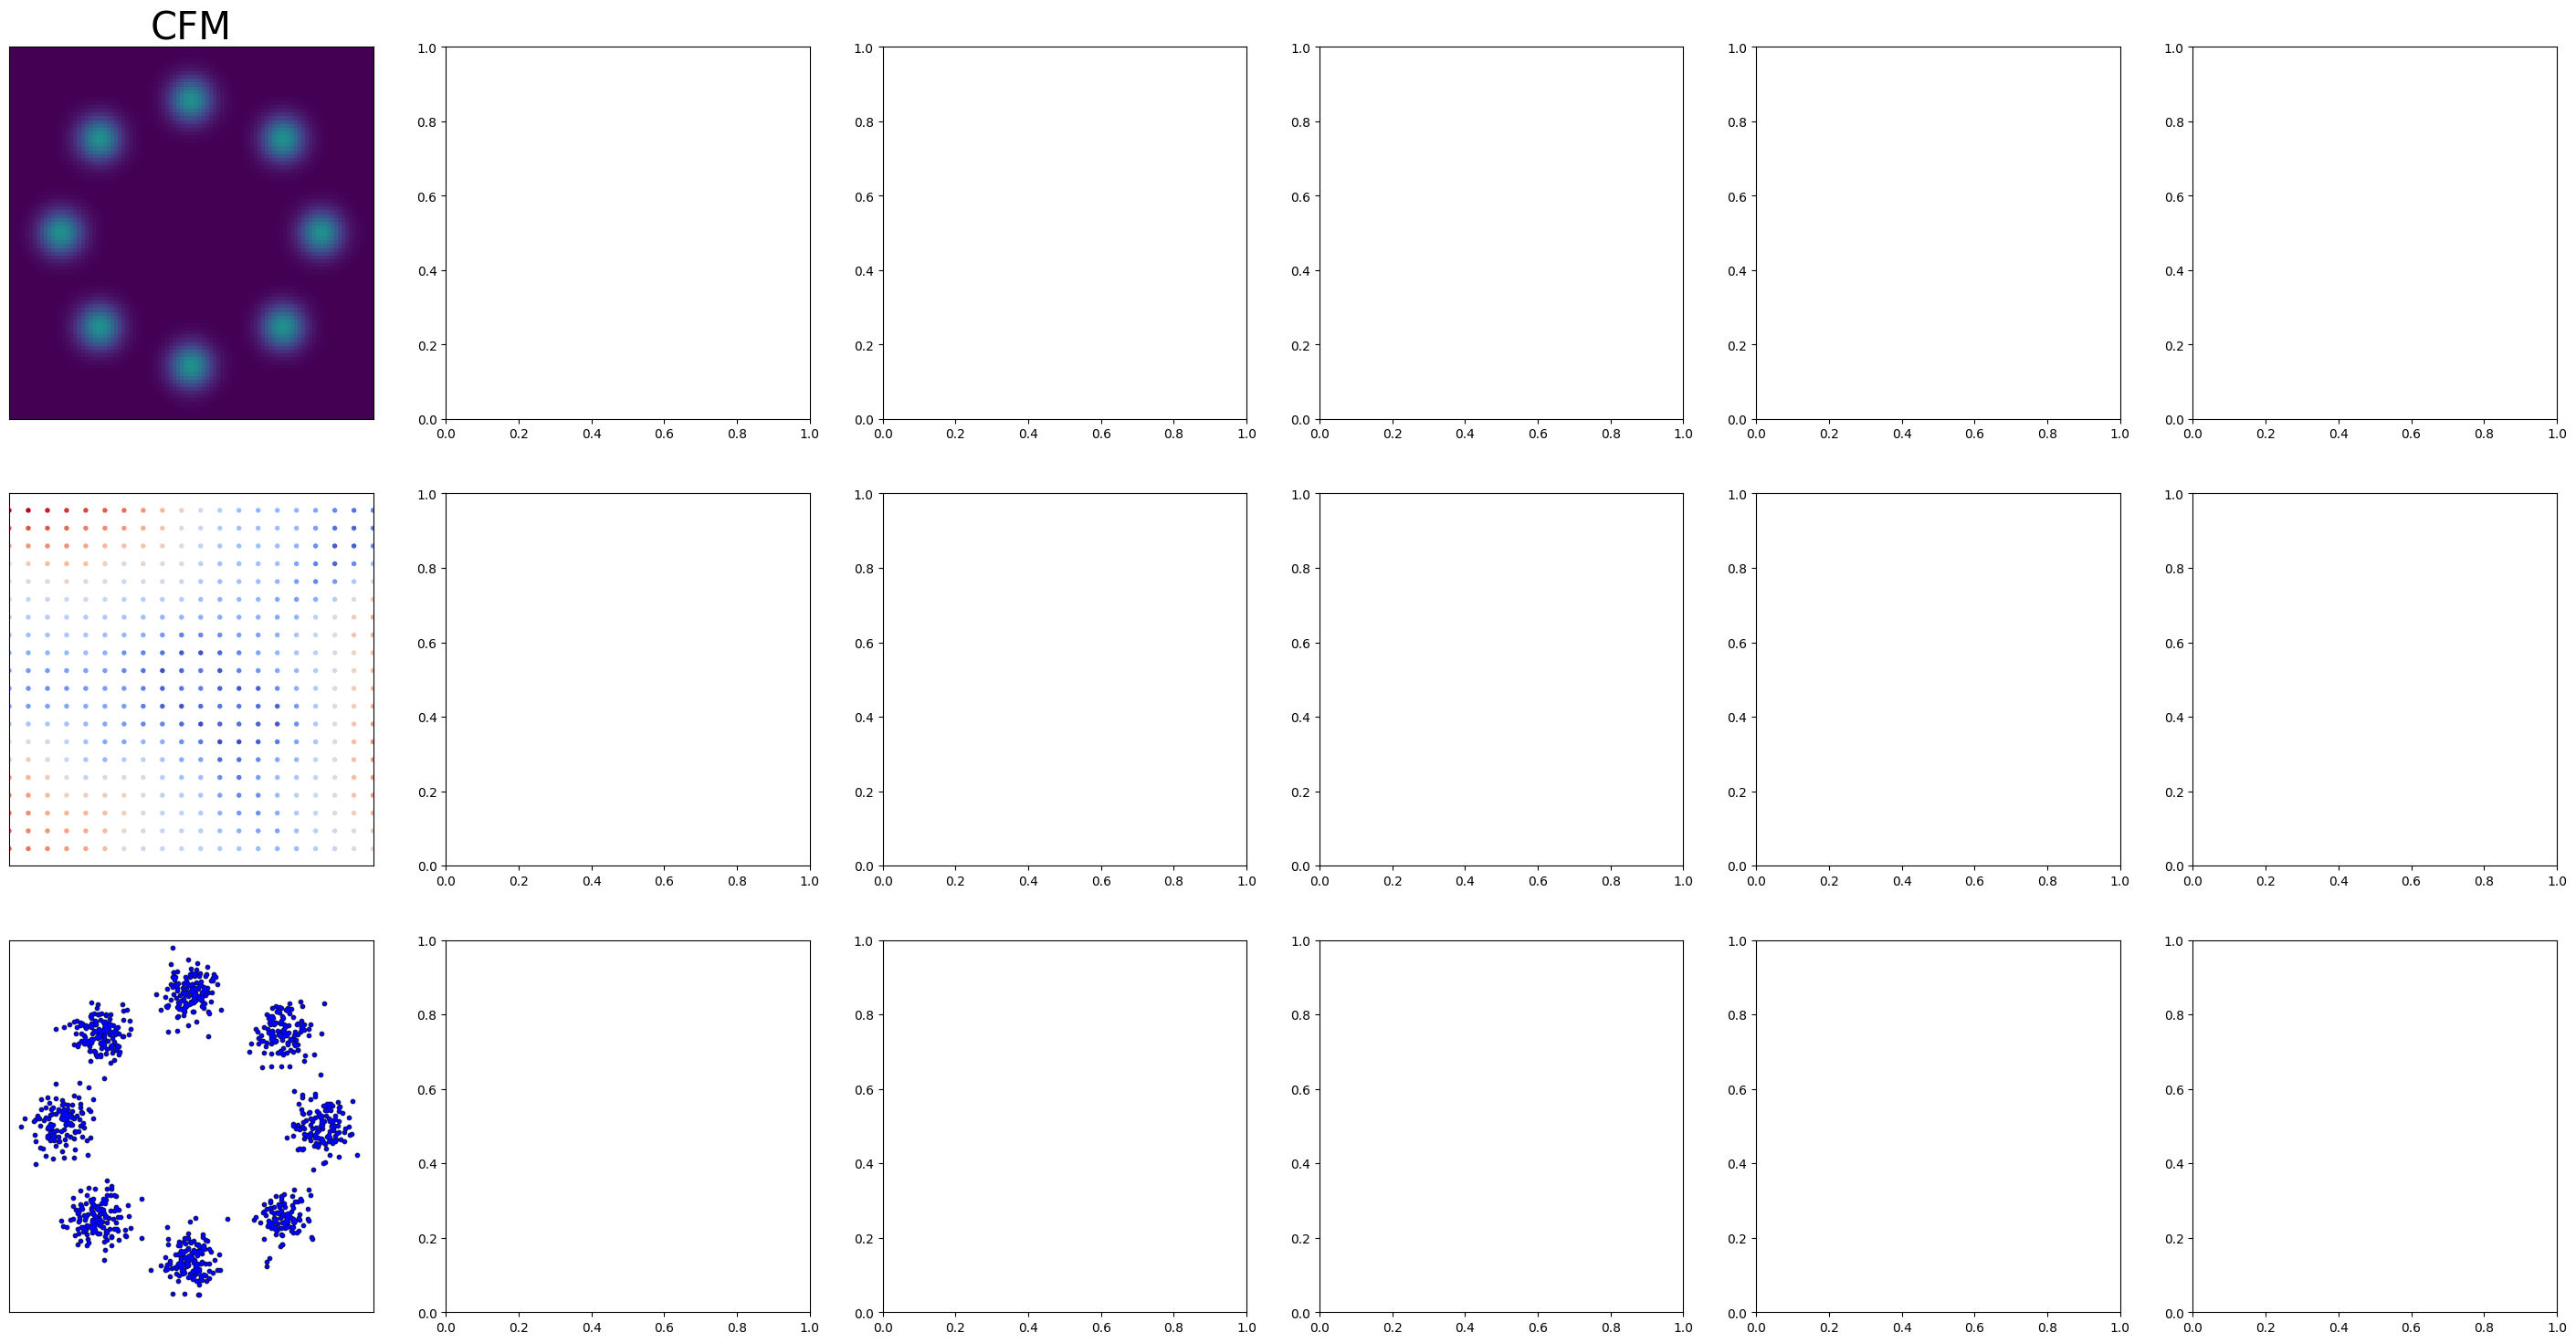

In [4]:
w = 7
points = 100j
points_real = 100
device = "cpu"
Y, X = np.mgrid[-w:w:points, -w:w:points]
gridpoints = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1)).type(torch.float32)
points_small = 20j
points_real_small = 20
Y_small, X_small = np.mgrid[-w:w:points_small, -w:w:points_small]
gridpoints_small = torch.tensor(np.stack([X_small.flatten(), Y_small.flatten()], axis=1)).type(
    torch.float32
)

torch.manual_seed(42)
sample = sample_8gaussians(1024)
ts = torch.linspace(0, 1, 101)
trajs = {}
for name, model in models.items():
    nde = NeuralODE(DEFunc(torch_wrapper(model)), solver="euler").to(device)
    # with torch.no_grad():
    traj = nde.trajectory(sample.to(device), t_span=ts.to(device)).detach().cpu().numpy()
    trajs[name] = traj
for i, t in enumerate(ts):
    names = [
        "CFM",
        "Action-Matching",
        "Action-Matching (Swish)",
        "VP-CFM",
        "SB-CFM (ours)",
        "OT-CFM (ours)",
    ]
    fig, axes = plt.subplots(3, len(names), figsize=(6 * len(names), 6 * 3))
    for axis, name in zip(axes.T, names):
        model = models[name]
        cnf = DEFunc(CNF(model))
        nde = NeuralODE(cnf, solver="euler", sensitivity="adjoint")
        cnf_model = torch.nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde)
        with torch.no_grad():
            if t > 0:
                aug_traj = (
                    cnf_model[1]
                    .to(device)
                    .trajectory(
                        Augmenter(1, 1)(gridpoints).to(device),
                        t_span=torch.linspace(t, 0, 201).to(device),
                    )
                )[-1].cpu()
                log_probs = log_8gaussian_density(aug_traj[:, 1:]) - aug_traj[:, 0]
            else:
                log_probs = log_8gaussian_density(gridpoints)
        log_probs = log_probs.reshape(Y.shape)
        ax = axis[0]
        ax.pcolormesh(X, Y, torch.exp(log_probs), vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)
        ax.set_ylim(-w, w)
        ax.set_title(f"{name}", fontsize=30)
        # Quiver plot
        # with torch.no_grad():
        out = model(
            torch.cat(
                [gridpoints_small, torch.ones((gridpoints_small.shape[0], 1)) * t], dim=1
            ).to(device)
        )
        out = out.reshape([points_real_small, points_real_small, 2]).cpu().detach().numpy()
        ax = axis[1]
        ax.quiver(
            X_small,
            Y_small,
            out[:, :, 0],
            out[:, :, 1],
            np.sqrt(np.sum(out**2, axis=-1)),
            cmap="coolwarm",
            scale=50.0,
            width=0.015,
            pivot="mid",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)

        ax = axis[2]
        sample_traj = trajs[name]
        ax.scatter(sample_traj[0, :, 0], sample_traj[0, :, 1], s=10, alpha=0.8, c="black")
        ax.scatter(sample_traj[:i, :, 0], sample_traj[:i, :, 1], s=0.2, alpha=0.2, c="olive")
        ax.scatter(sample_traj[i, :, 0], sample_traj[i, :, 1], s=4, alpha=1, c="blue")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)
        ax.set_ylim(-w, w)
    plt.suptitle(f"8gaussians to Moons T={t:0.2f}", fontsize=40)
    os.makedirs("figures/trajectory/v3/", exist_ok=True)
    plt.savefig(f"figures/trajectory/v3/{t:0.2f}.png", dpi=40)
    plt.close()

In [5]:
gif_name = "8gaussians-to-moons"
with imageio.get_writer(f"{gif_name}.gif", mode="I") as writer:
    for filename in [f"figures/trajectory/v3/{t:0.2f}.png" for t in ts] + [
        f"figures/trajectory/v3/{ts[-1].item():0.2f}.png"
    ] * 10:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\shahs\AppData\Local\Temp\ipykernel_17444\4293379450.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: No such file: 'c:\Users\shahs\conditional-flow-matching\figures\trajectory\v3\0.00.png'

In [11]:
models = {
    "CFM": torch.load("./models/8gaussian-moons/cfm_v1.pt"),
    "OT-CFM (ours)": torch.load("models/8gaussian-moons/otcfm_v1.pt"),
    "SB-CFM (ours)": torch.load("models/8gaussian-moons/sbcfm_v1.pt"),
    "VP-CFM": torch.load("models/8gaussian-moons/stochastic_interpolant_v1.pt"),
    # "FM": torch.load("models/8gaussian-moons/flow_matching_v1.pt"),
    # "VP-SDE": torch.load("models/8gaussian-moons/vp_flow_v1.pt"),
    "Action-Matching": torch.load("models/8gaussian-moons/action_matching_v1.pt"),
    "Action-Matching (Swish)": torch.load("models/8gaussian-moons/action_matching_swish_v1.pt"),
}

In [15]:
w = 7
points = 100j
points_real = 100
device = "cpu"
Y, X = np.mgrid[-w:w:points, -w:w:points]
gridpoints = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1)).type(torch.float32)
points_small = 20j
points_real_small = 20
Y_small, X_small = np.mgrid[-w:w:points_small, -w:w:points_small]
gridpoints_small = torch.tensor(np.stack([X_small.flatten(), Y_small.flatten()], axis=1)).type(
    torch.float32
)

torch.manual_seed(42)
sample = sample_normal(1024)
ts = torch.linspace(0, 1, 101)
trajs = {}
for name, model in models.items():
    nde = NeuralODE(DEFunc(torch_wrapper(model)), solver="euler").to(device)
    # with torch.no_grad():
    traj = nde.trajectory(sample.to(device), t_span=ts.to(device)).detach().cpu().numpy()
    trajs[name] = traj
names = [
    # "VP-SDE",
    # "FM",
    "CFM",
    "Action-Matching",
    "Action-Matching (Swish)",
    "VP-CFM",
    "SB-CFM (ours)",
    "OT-CFM (ours)",
]
for i, t in enumerate(ts):
    fig, axes = plt.subplots(3, len(names), figsize=(len(names) * 6, len(names) * 3))

    for axis, name in zip(axes.T, names):
        model = models[name]
        cnf = DEFunc(CNF(model))
        nde = NeuralODE(cnf, solver="euler")
        cnf_model = torch.nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde)
        with torch.no_grad():
            if t > 0:
                aug_traj = (
                    cnf_model[1]
                    .to(device)
                    .trajectory(
                        Augmenter(1, 1)(gridpoints).to(device),
                        t_span=torch.linspace(t, 0, 201).to(device),
                    )
                )[-1].cpu()
                log_probs = log_normal_density(aug_traj[:, 1:]) - aug_traj[:, 0]
            else:
                log_probs = log_normal_density(gridpoints)
        log_probs = log_probs.reshape(Y.shape)
        ax = axis[0]
        ax.pcolormesh(X, Y, torch.exp(log_probs))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)
        ax.set_ylim(-w, w)
        ax.set_title(f"{name}", fontsize=30)
        # Quiver plot
        # with torch.no_grad():
        out = model(
            torch.cat(
                [gridpoints_small, torch.ones((gridpoints_small.shape[0], 1)) * t], dim=1
            ).to(device)
        )
        out = out.reshape([points_real_small, points_real_small, 2]).cpu().detach().numpy()
        ax = axis[1]
        ax.quiver(
            X_small,
            Y_small,
            out[:, :, 0],
            out[:, :, 1],
            np.sqrt(np.sum(out**2, axis=-1)),
            cmap="coolwarm",
            scale=50.0,
            width=0.015,
            pivot="mid",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)

        ax = axis[2]
        sample_traj = trajs[name]
        ax.scatter(sample_traj[0, :, 0], sample_traj[0, :, 1], s=10, alpha=0.8, c="black")
        ax.scatter(sample_traj[:i, :, 0], sample_traj[:i, :, 1], s=0.2, alpha=0.2, c="olive")
        ax.scatter(sample_traj[i, :, 0], sample_traj[i, :, 1], s=4, alpha=1, c="blue")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-w, w)
        ax.set_ylim(-w, w)
    plt.suptitle(f"Gaussian to Moons T={t:0.2f}", fontsize=40)
    os.makedirs("figures/trajectory2/v3/", exist_ok=True)
    plt.savefig(f"figures/trajectory2/v3/{t:0.2f}.png", dpi=40)
    plt.close()

In [16]:
gif_name = "gaussians-to-moons"
ts = torch.linspace(0, 1, 101)
with imageio.get_writer(f"{gif_name}.gif", mode="I") as writer:
    for filename in [f"figures/trajectory2/v3/{t:0.2f}.png" for t in ts] + [
        f"figures/trajectory2/v3/{ts[-1].item():0.2f}.png"
    ] * 10:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_10858/1452409276.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
